# Описание
Постановка задачи: даны записи с видеокамер ТЦ, нужно определить возвратных посетителей по этим записям.
в данной тетрадке приведена последовательность действий обработки нового видео, выделения из него изображений персон и проверки, есть ли среди этих персон уже известные

In [2]:
# импорт библиотеки
import sys
import os
import tensorflow as tf
import numpy as np
sys.path.insert(0, '../../verificator')
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

### Данные:
Есть несколько наборов видеозаписей с разных камер. Основное время работал с записями с двух камер наблюдения с очень низким качеством:

In [3]:
import matplotlib.pyplot as plt
import cv2

In [146]:
img_1 = os.path.expanduser('~/d_test/data/pics/final_sets/clean_cam_1_thr_0.5/train/1/1_1.jpg')
img_2 = os.path.expanduser('~/d_test/data/pics/final_sets/clean_cam_2_thr_0.5/train/600/600_1.jpg')

In [154]:
ary1 = cv2.cvtColor(cv2.imread(img_1), cv2.COLOR_BGR2RGB)
ary2 = cv2.cvtColor(cv2.imread(img_2), cv2.COLOR_BGR2RGB)

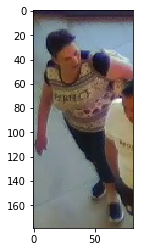

In [158]:
# Изображение персоны с камеры 1
plt.imshow(ary1)
plt.show()

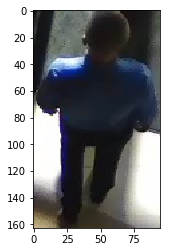

In [159]:
# Изображение персоны с камеры 2
plt.imshow(ary2)
plt.show()

### Шаг 1: обработка видео и сохранение изображений персон


In [4]:
'''
обработка видео производится с помощью детектора darkflow (yolo) и трекера Sort
'''
# инициализируем детектор
#
# папка с параметрами инициализации 
build_path = '/home/shareduser/d_test/data/models/yolo_init_config'
# config для darkflow
model = os.path.join(build_path, 'cfg', 'yolo-people.cfg')
cfg = os.path.join(build_path, 'cfg')
labels = os.path.join(build_path, 'labels.txt')
# папка с весами и чекпоинтами для дообученной модели
trained_model_path = '/home/shareduser/d_test/data/models/darkflow_retrain_all_imgs/full_data'
backup_path = os.path.join(trained_model_path, 'ckpt')
summary_path = os.path.join(trained_model_path, 'summary')
# опции детектора
options = {}
options['model'] = model
options['load'] = -1      #загружаем из последнего чекпойнта
options['config'] = cfg
options['labels'] = labels
options['gpu'] = 0.1
options['threshold'] = 0.5
options['backup'] = backup_path
options['summary'] = summary_path

In [ ]:
# создали детектор
from verificator.detector import Detector
detector = Detector(options)

In [6]:
# создаем трекер
from sort.sort import Sort
tracker = Sort()

In [8]:
# папка с видеофайлами для обработки
video_path_1 = '/home/shareduser/d_test/data/videos/cam_1' # камера 1
video_path_2 = '/home/shareduser/d_test/data/videos/cam_2' # камера 2
# папка для сохранения изображений
img_saving_path = '/home/shareduser/d_test/data/pics/dummy/cam_1_thr_0.5'
if not os.path.exists(img_saving_path):
    os.mkdir(img_saving_path)

In [ ]:
# запускаем обработку видео.
'''
detector.detect_and_save(
    tracker,
    save_mode='images',
    video_file_path=video_path_1,
    img_saving_path=img_saving_path,
    show_video=False)
'''

'''
обработанные и вычищенные изображения лежат в /home/shareduser/d_test/data/pics/final_sets
'''

### Шаг 2: получение низкоразмерных фич из изображений

In [12]:
'''
Низкоразмерные фичи получаем с помощью модели Inception в tensorflow
'''
from verificator.feature_extractor import InceptionExtractor
model_path = '/home/shareduser/d_test/data/models/inception/classify_image_graph_def.pb'
inc_extr = InceptionExtractor(model_path)

In [13]:
images_paths = [os.path.expanduser('~/d_test/data/pics/final_sets/clean_cam_1_thr_0.5/train'),
                os.path.expanduser('~/d_test/data/pics/final_sets/clean_cam_2_thr_0.5/train'),
                os.path.expanduser('~/d_test/data/pics/final_sets/cam_1_2/train')]

In [14]:
saving_names = ['cam_1', 'cam_2', 'cam_1_2']
root_saving_path = os.path.expanduser('~/d_test/data/models/final_models/features/inception_features')

In [ ]:
# фичи созданы и сохоанены, при желании - можно uncomment and run
'''
for im_path, s_name in zip(images_paths, saving_names):
    # при кодировке в качестве labels используется имя папки с изображениями
    # feature имеет размерность 2048
    labels, features = inc_extr.encode_from_dirs(im_path)
    saving_path = os.path.join(root_saving_path, s_name)
    if not os.path.exists(saving_path):
        os.mkdir(saving_path)
    np.save(os.path.join(saving_path, s_name+'_inception_features.npy'), features)
    np.save(os.path.join(saving_path, s_name+'_inception_labels.npy'), labels)
'''

### Шаг 3: получение фич для модели TPE  (Triplet Probabilistic Embedding), https://arxiv.org/abs/1604.05417, https://habrahabr.ru/post/317798/

In [4]:
from verificator.tpe_predictor import TPEPredictor

Using TensorFlow backend.


In [5]:
n_in = 2048 # размерность inception - фич
n_out = 512 # размерность tpe-фич, может быть метапараметром для тюнинга
tpe_predictor = TPEPredictor(n_in, n_out)

../../verificator/verificator/tpe_model/tpe_model_builder.py:43: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(512, use_bias=False, weights=[array([[ ..., input_dim=2048, activation="linear")`
  base_model.add(Dense(n_out, input_dim=n_in, bias=False, weights=[W_pca], activation='linear'))
../../verificator/verificator/tpe_model/tpe_model_builder.py:49: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  e = merge([a_emb, p_emb, n_emb], mode=triplet_merge, output_shape=triplet_merge_shape)
/home/shareduser/.local/lib/python3.5/site-packages/keras/legacy/layers.py:460: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
../../verificator/verificator/tpe_model/tpe_model_builder.py:50: UserWarning: Update your `Model` call to the Keras 2 API: `M

In [7]:
# загрузка весов обученной tpe-модели:
tpe_weights = os.path.expanduser('~/d_test/data/models/final_models/weights/inception/cam_1/cam_1_best.h5')

In [8]:
tpe_predictor.load_weights(tpe_weights)

tpe_predictor переводит Inception-фичи в TPE-фичи. Чтобы определить, являются ли два изображения одной персоной или разными, ищем cosine_similarity между TPE-фичами. Поскольку TPE-фичи нормированы, то оценку схожести для двух изображений проводим по критерию:
tpe_features_1 @ tpe_features_2.T >= tpe_threshold,
где tpe_threshold - параметр, при котором FAR == FRR (параметр ищется при обучении модели).

#### Тест 1. Повторное распознавание заведомо известных персон

In [4]:
# загружаем сохраненные inception-фичи для камеры 1 для train- и test- выборок. 
known_path = os.path.expanduser('~/d_test/data/models/final_models/features/inception_features/cam_1')
test_path = os.path.expanduser('~/d_test/data/models/final_models/features/inception_features/test/cam_1')

inc_known_features = np.load(os.path.join(known_path, 'cam_1_inception_features.npy'))
known_labels = np.load(os.path.join(known_path, 'cam_1_inception_labels.npy'))

inc_test_features = np.load(os.path.join(test_path, 'cam_1_test_features.npy'))
test_labels = np.load(os.path.join(test_path, 'cam_1_test_labels.npy'))

In [9]:
# tpe-фичи для train-выборки
tpe_known_features = tpe_predictor.predict(inc_known_features)

In [10]:
# tpe-фичи для test-выборки
tpe_test_features = tpe_predictor.predict(inc_test_features)

In [37]:
# оценим качество на target-попытках
tpe_threshold = 0.2947738116437738 # порог признания похожести между двумя отдельно взятыми векторами
in_class_threshold = 0.8 # порог признания похожести между отдельным изображением и набором изображений одного объекта
target_scores = np.array([])
for label in np.unique(test_labels):
    test_person_features = tpe_test_features[np.where(test_labels == label)] # выбираем фичи одной персоны из test-выборки
    known_person_features = tpe_known_features[np.where(known_labels == label)] # выбираем фичи той же персоны из train-выборки
    scores = (test_person_features@known_person_features.T >= tpe_threshold)
    target_scores = np.append(target_scores, np.sum(scores, axis=1)/scores.shape[1] >= in_class_threshold)
print('target-score для порога в своем классе {}: {}'.format(in_class_threshold, np.sum(target_scores)/test_labels.shape[0]))

target-score для порога в своем классе 0.8: 0.9547024952015355


In [51]:
# оценим качество на imposter-попытках
in_class_threshold = 0.8 # порог признания похожести между отдельным изображением и набором изображений одного объекта
imposter_scores = np.array([])
for label in np.unique(test_labels):
    test_person_features = tpe_test_features[np.where(test_labels == label)] # выбираем фичи одной персоны из test-выборки
    other_labels = known_labels[np.where(known_labels != label)]
    other_labels = np.unique(other_labels)
    for other_label in other_labels:
        other_features = tpe_known_features[np.where(known_labels == other_label)]
        scores = (test_person_features@other_features.T >= tpe_threshold)
        imposter_scores = np.append(imposter_scores, np.sum(scores, axis=1)/scores.shape[1] >= in_class_threshold)
print(np.sum(imposter_scores)/len(imposter_scores))

0.00911181696194


Результат: target-score 0.95, imposter-score 0.01 для известного набора персон

#### Тест 2. Идентификация неизвестных персон

In [67]:
"""
Записи с другой видеокамеры в ТЦ. Будем считать, что все персоны, которых детектировала эта камера, неизвестны.
Качество изображения со второй камеры сильно отличается (в худшую сторону) от качества камеры 1,
поэтому определение качества работы модели в данном случае происходит на весах модели, не обученной классифицировать
изображения с камеры 2, что может привести к ухудшению показателей (так оно и будет).
Данный тест проводится для того, чтобы определить, насколько модель эффективна в определении новых персон.
"""
unknown_path = os.path.expanduser('~/d_test/data/models/final_models/features/inception_features/cam_2')

In [68]:
inc_unknown_features = np.load(os.path.join(unknown_path, 'cam_2_inception_features.npy'))
unknown_labels = np.load(os.path.join(unknown_path, 'cam_2_inception_labels.npy'))
tpe_unknown_features = tpe_predictor.predict(inc_unknown_features)

In [87]:
# все id персон со второй камеры отличаются от id персон с первой камеры
np.where(known_labels == unknown_labels)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  


(array([], dtype=int64),)

In [75]:
print('кол-во изображений, полученных с камеры 2: {}'.format(unknown_labels.shape[0]))
print('кол-во уникальных персон, полученных с камеры 2: {}'.format(np.unique(unknown_labels).shape[0]))

кол-во изображений, полученных с камеры 2: 3755
кол-во уникальных персон, полученных с камеры 2: 143


In [77]:
# выберем 500 случайных изображений персон из выборки камеры 2
indices = np.random.choice(unknown_labels.shape[0], 500, replace=False)
test_unknown_labels = unknown_labels[indices]
test_unknown_features = tpe_unknown_features[indices]

In [78]:
test_unknown_features.shape

(500, 512)

In [135]:
all_un_scores = None
for label in np.unique(known_labels):
    known_person_features = tpe_known_features[np.where(known_labels == label)]
    scores = (test_unknown_features @ known_person_features.T >= tpe_threshold)
    scores =(np.sum(scores, axis =1)/scores.shape[1] >= in_class_threshold)[np.newaxis].reshape(500,1)
    if all_un_scores is None:
        all_un_scores = scores
    else:
        all_un_scores = np.concatenate((all_un_scores, scores), axis = 1)

In [136]:
"""
поскольку мы считаем, что все персоны с камеры 2 являются неизвестными, то должно выполняться, что персона
не должна быть распознана ни для одного известного класса, поэтому оценка числа ошибочных распознаваний:
"""
np.count_nonzero(np.sum(all_un_scores, axis=1))/len(np.sum(all_un_scores, axis=1))

0.938

Таким образом, практически в 100% случаев в данной постановке задачи невозможно определить новую персону по одному ее изображению. В настоящее время веду поиск более надежного критерия отсечения и дообучаю модели для лучшего результата. 
Вариантом использования модели может служить поиск наиболее похожих персон для новых данных с камеры и ручное определение того, является ли эта персона уже известной.

#### Тест 3. Идентификация неизвестных персон №2

In [ ]:
"""
В данном тесте модель TPE обучена на изображениях с обех камер ТЦ. Из обучающей выборки были убраны изображения 50 персон.
Будем сичтать, что эти персоны наверняка являются неизвестными.
Для каждой неизвестной персоны есть набор ее изображений. Идентификацию будем проводить в два этапа:
1) для каждого изображения неизвестной персоны проведем сравнение с каждым классом известных персон. Если внутри класса известной
    персоны количество узнаваний будет >= in_class_threshold, то будем считать, что данное изображение неизвестной персоны
    условно распознано для данного класса известной персоны
2) если количество условно распознанных изображений неизвестной персоны для данного класса известной персоны >= in_class_threshold
    от общего кол-ва изображений этой персоны, то будем считать, что данная персона распознана. 
Пример.
Пусть кол-во изображений для неизвестной персоны с id=100 равно 10. Допустим, мы сравниваем ее с известной персоной с id=50,
и кол-во изображений для id=50 равно 20. Сравнивая каждое изображение персоны id=100 с изображениями id=50, получим матрицу
размера [10, 20]. Просуммировав по каждой строке и подели на длину строки, получим вектор размерности 10. Если значение элемента
>= in_class_threshold, то считаем, что данное изображение персоны id=100 распознано. 
Если кол-во распознанных изображений неизвестной персоны больше 10*in_class_threshold, то будем считать, что персона id =100 
- это персона id = 50, либо нет в противном случае. 
Проведя сравнение со всеми известными персонами, делаем вывод, о том, является ли персона id=100 новой или уже известной.
"""

In [6]:
w_saving_path_50_excl = os.path.expanduser('~/d_test/data/models/final_models/weights/inception/cam_1_2_50_excluded')
excluded_labels = np.load(os.path.join(w_saving_path_50_excl, 'excluded_labels.npy')) # персоны, которые были полностью исключены

In [7]:
inc_feat_1_2 = os.path.expanduser('~/d_test/data/models/final_models/features/inception_features/cam_1_2')
features_1_2 = np.load(os.path.join(inc_feat_1_2, 'cam_1_2_inception_features.npy'))
labels_1_2 = np.load(os.path.join(inc_feat_1_2, 'cam_1_2_inception_labels.npy'))

In [9]:
# выбираем фичи и лейблы персон, которые использовались при обучении модели:
labels_50 = labels_1_2
features_50 = features_1_2

for l in excluded_labels:
    new_indices = np.where(labels_50 != l)
    labels_50 = labels_50[new_indices]
    features_50 = features_50[new_indices]

In [10]:
# выбираем фичи и лейблы персон, которые были исключены при обучении модели (полностью неизвестные персоны):
excluded_labels_50 = np.array([])
excluded_features_50 = None
for l in excluded_labels:
    new_indices = np.where(labels_1_2 == l)
    excluded_labels_50 = np.append(excluded_labels_50, labels_1_2[new_indices])
    if excluded_features_50 is None:
        excluded_features_50 = features_1_2[new_indices]
    else:
        excluded_features_50 = np.vstack([excluded_features_50, features_1_2[new_indices]])

In [11]:
print('Кол-во известных персон, на которых обучена модель: {}'.format(len(np.unique(labels_50))))

Кол-во известных персон, на которых обучена модель: 659


In [12]:
print('Кол-во неизвестных персон: {}'.format(len(np.unique(excluded_labels_50))))

Кол-во неизвестных персон: 50


In [171]:
print('Размерность фич: {}'.format(features_50.shape[1]))

Размерность фич: 2048


In [13]:
# загружаем модель:
tpe_predictor.load_weights(os.path.join(w_saving_path_50_excl, 'ca_1_2_50_excl_best.h5'))

In [14]:
# получаем значение параметра для EER (equal error rate) обученной модели:
with open(os.path.join(w_saving_path_50_excl, 'deer.txt'), 'r') as f:
    tpe_threshold = float(f.read())
print(tpe_threshold)

0.314


In [15]:
# получаем TPE-фичи:
tpe_features_50 = tpe_predictor.predict(features_50)
tpe_excluded_features_50 = tpe_predictor.predict(excluded_features_50)

In [16]:
print('Размерность TPE-фич: {}'.format(tpe_features_50.shape[1]))

Размерность TPE-фич: 512


In [17]:
tpe_threshold = 0.31419761975606286
in_class_threshold = 0.75 # подобрали значение параметра так, чтобы FAR=FRR == EER
all_un_scores = None
all_pers_id = []
for label in np.unique(excluded_labels_50):
    unknown_person_features = tpe_excluded_features_50[np.where(excluded_labels_50 == label)]
    pers_identified = []
    for known_label in np.unique(labels_50):   # для каждой известной персоны
        known_person_features = tpe_features_50[np.where(labels_50 == known_label)]  # берем фичи этой персоны
        scores = unknown_person_features @ known_person_features.T >= tpe_threshold  # проводим идентификацию каждого изображения с каждым
        scores = np.sum(scores, axis=1)/scores.shape[1] >= in_class_threshold        # проверяем, идентифицировано ли изображение неизвестной персоны
        scores = np.sum(scores)/scores.shape[0] >= in_class_threshold                # проверяем, сколько изображений неизвестной персоны идентифицировано
        pers_identified.append(scores)
    # pers_identified - флаги идентификации неизвестного изображения с каждым  из известных классов
    all_pers_id.append(sum(pers_identified)) # если есть идентификации, то в итоговый результат попадет ненулевое значение 
print('FAR: {}'.format(len(np.nonzero(all_pers_id)[0])/len(all_pers_id))) # смотрим, сколько есть ненулевых значений из всех
                                                                          # каждое ненулевое значение - ошибочная идентификация

tar_pers_id = [] # здесь мы считаем target-scores (насколько в данной постановке может быть идентифицирован свой же класс)
for label in np.unique(excluded_labels_50):
    person_features = tpe_excluded_features_50[np.where(excluded_labels_50 == label)]
    scores = person_features @ person_features.T >= tpe_threshold
    scores = np.sum(scores, axis=1)/scores.shape[1] >= in_class_threshold
    scores = np.sum(scores)/scores.shape[0] >= in_class_threshold
    tar_pers_id.append(scores)
print('FRR: {}'.format(1-sum(tar_pers_id)/len(tar_pers_id)))

FAR: 0.24
FRR: 0.30000000000000004


Вывод: EER = 30% для идентификации персоны по набору изображений. Здесь возникает вопрос о корректности оценки, поскольку кол-во известных и неизвестных персон сильно отличается (659 против 50), однако даже такая оценка дает возможность понять, работает ли эта модель в принципе. В принципе - работает.

#### Тест 4. Повторная идентификация персон

In [ ]:
'''
В данном тесте оценим точность повторных распознаваний персон.
Из данных для 50 заведомо неизвестных персон выберем классы, для которых кол-во изображений не меньше 30.
Из выбранных классов выберем по 30 изображений и разделим на три группы по 10 изображений в каждой.
Таким образом, для каждой неизвестной персоны будем иметь набор tpe-признаков следующего вида:
[[набор1: 10 признаков],[набор2: 10 признаков],[набор3: 10 признаков]]
Для каждого набора проведем последовательную идентификацию с данными по известным персонам по следующему алгоритму:
    1) если первый набор признаков не идентифицирован с известными классами, то считаем, что это данные для нового класса,
    добавляем эти данные к набору известных классов и увеличиваем счетчик новых персон на 1
    2) проводим идентификацию по второму набору признаков, если будет верифицирован верный класс - класс
    новой персоны из шага (1), то увеличиваем счетчик успешной ре-идентификации на 1
    3) повторяем шаг (2)
В данном алгоритме результат повторного узнавания будет занижен, т.к. в случае сильной вариации изображений персоны внутри класса
будет проводиться более жесткое сравнение, чем если бы данные внутри класса были как-то систематизированы по вариативности
'''

In [23]:
# строим информацию по кол-ву изображений в классах тестовой выборки:
excl_info = {}
for lab in np.unique(excluded_labels_50):
    excl_info[int(lab)] = len(excluded_labels_50[np.where(excluded_labels_50 == lab)])

In [130]:
# выбираем метки классов, для которыех число изображений не меньше 30:
excluded_labels_30_and_more = np.array([])
N =30
for k, v in excl_info.items():
    if v >= N:
        excluded_labels_30_and_more = np.append(excluded_labels_30_and_more, k)
NCLASSES = len(excluded_labels_30_and_more)
print('Кол-во классов персон для теста: {}'.format(NCLASSES))

Кол-во классов персон для теста: 35


In [131]:
# выбираем ровно по 30 признаков:
tpe_excluded_features_30_strict = None
excluded_labels_30_strict = np.array([])
for lab in np.unique(excluded_labels_30_and_more):
    new_indices = np.where(excluded_labels_50 == lab)
    excluded_labels_30_strict = np.append(excluded_labels_30_strict, excluded_labels_50[new_indices][:N])
    if tpe_excluded_features_30_strict is None:
        tpe_excluded_features_30_strict = tpe_excluded_features_50[new_indices][:N]
    else:
        tpe_excluded_features_30_strict = np.vstack([tpe_excluded_features_30_strict, tpe_excluded_features_50[new_indices][:N]])

In [132]:
tpe_excluded_features_30_strict.shape, excluded_labels_30_strict.shape

((1050, 512), (1050,))

In [133]:
# разбиваем данные на тестовые батчи
split_labels_30 = excluded_labels_30_strict.reshape(NCLASSSES,int(N/10),10)
split_tpe_features_30 = tpe_excluded_features_30_strict.reshape(NCLASSES,int(N/10),10,512)

In [134]:
split_tpe_features_30.shape

(35, 3, 10, 512)

In [136]:
# перебираем различные пороги внутри классов для трех последовательных верификаций
result = {}
for in_class_threshold in np.linspace(0.5, 0.9, 9):
    # каждый раз переинициализируем списки персон
    known_persons_features = tpe_features_50.copy()
    known_persons_labels = labels_50.copy()
    new_persons = []
    logs = {}
    #in_class_threshold = 0.9
    for features_batch, labels_batch in zip(split_tpe_features_30, split_labels_30):
        #print('---------------------------------')
        for batch_10, labels_batch_10 in zip(features_batch, labels_batch):
            all_scores = {}
            for known_label in np.unique(known_persons_labels):
                known_person = known_persons_features[np.where(known_persons_labels==known_label)]
                scores = (batch_10 @ known_person.T >= tpe_threshold)
                scores = np.sum(scores, axis=1)/scores.shape[1] >= in_class_threshold        # проверяем, идентифицировано ли изображение неизвестной персоны
                scores = np.sum(scores)/scores.shape[0] >= in_class_threshold                # проверяем, сколько изображений неизвестной персоны идентифицировано
                # для известных классов пишем верифицирован/нет
                all_scores[known_label] = scores
            if not sum(all_scores.values()):
                # нашли новую персону
                #print('new person {}'.format(np.unique(labels_batch_10)))
                # добавляем ее фичи к набору известных персон
                known_persons_features = np.vstack([known_persons_features, batch_10])
                known_persons_labels = np.append(known_persons_labels, labels_batch_10)
                new_persons.append(labels_batch_10[0])
                # в log пишем информацию о новой персоне
                if labels_batch_10[0] not in logs.keys():
                    # на первом месте в списки логов будет стоять "истинное" первое появление
                    logs[labels_batch_10[0]] = [['new']]
                else:
                    # здесь будет писаться ложное первое появление
                    logs[labels_batch_10[0]].append(['new'])
            else:
                # если персона узнана, пишем, на кого из известных она похожа
                similar_persons = [k for k,v in all_scores.items() if v]
                #print('person {} is similar to {}'.format(labels_batch_10[0], similar_persons))
                if labels_batch_10[0] not in logs.keys():
                    logs[labels_batch_10[0]] = [similar_persons]
                else:
                    logs[labels_batch_10[0]].append(similar_persons)

    # обрабатываем логи
    first_step_right = 0
    second_step_right = 0
    third_step_right = 0
    for k, v in logs.items():
        if v[0][0] == 'new':
            first_step_right += 1
            if k in v[1]:
                second_step_right += 1
                if k in v[2]:
                    third_step_right += 1
                    
    result[in_class_threshold] = (first_step_right/NCLASSES, second_step_right/NCLASSES, third_step_right/NCLASSES)

print(result)

{0.5: (0.02857142857142857, 0.02857142857142857, 0.02857142857142857), 0.55000000000000004: (0.11428571428571428, 0.11428571428571428, 0.11428571428571428), 0.59999999999999998: (0.11428571428571428, 0.11428571428571428, 0.11428571428571428), 0.80000000000000004: (0.7714285714285715, 0.45714285714285713, 0.2571428571428571), 0.69999999999999996: (0.45714285714285713, 0.2857142857142857, 0.2571428571428571), 0.90000000000000002: (0.9428571428571428, 0.11428571428571428, 0.08571428571428572), 0.85000000000000009: (0.9142857142857143, 0.08571428571428572, 0.05714285714285714), 0.65000000000000002: (0.37142857142857144, 0.2, 0.17142857142857143), 0.75: (0.7428571428571429, 0.42857142857142855, 0.22857142857142856)}


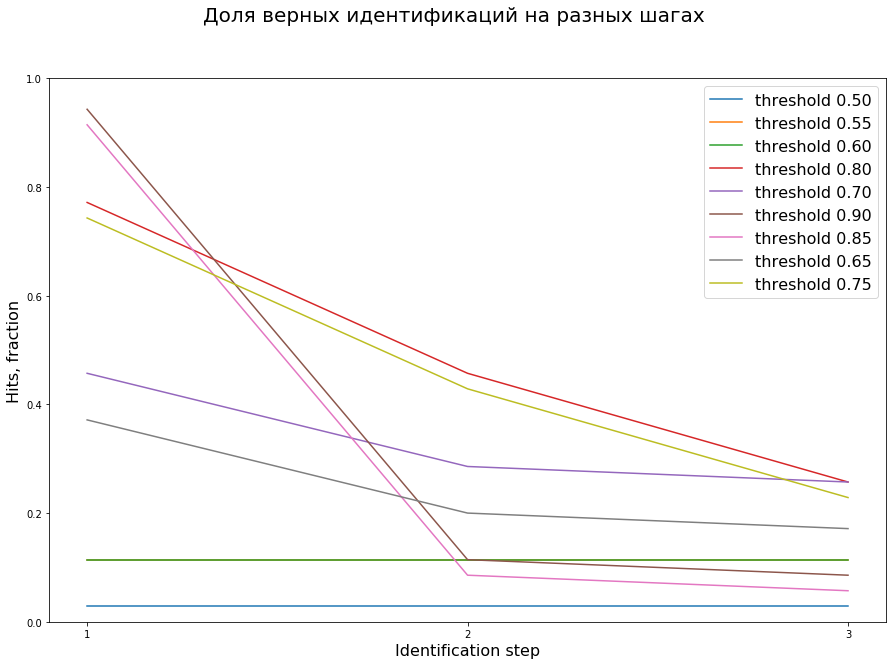

In [159]:
steps = (1,2,3)
cntr = 0
fig, ax = plt.subplots(figsize=(15,10))
for k, v in result.items():
    ax.plot(steps, v, label='threshold {:.2f}'.format(k))
    cntr += 1
ax.set_xlabel('Identification step')
ax.set_ylabel('Hits, fraction')
fig.suptitle('Доля верных идентификаций на разных шагах', fontsize=20)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
ax.legend(prop={'size': 16})
plt.ylim(ymin=0)
plt.ylim(ymax=1)
plt.xticks(steps)
for item in [ax.xaxis.label, ax.yaxis.label]:
    item.set_fontsize(16)
plt.show()